In [1]:
import sys, os
import math
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage

In [2]:
print('Python: {}'.format(sys.version))
print('Numpy: {}'.format(np.__version__))
print('Pandas: {}'.format(pd.__version__))
print('OpenCV: {}'.format(cv2.__version__))
print('Tensorflow: {}'.format(tf.__version__))
print('Matplotlib: {}'.format(mpl.__version__))
print('Scikit-Image: {}'.format(skimage.__version__))

Python: 3.8.3 (default, Jul  2 2020, 16:21:59) 
[GCC 7.3.0]
Numpy: 1.18.5
Pandas: 1.0.5
OpenCV: 4.5.1
Tensorflow: 2.2.0
Matplotlib: 3.2.2
Scikit-Image: 0.16.2


In [3]:
def psnr(target, ref):
    
    target_data = target.astype(np.float32)
    ref_data = ref.astype(np.float32)
    
    diff = ref_data - target_data
    diff = diff.flatten('C')
    
    rmse = np.sqrt(np.mean(diff ** 2.))
    
    return 20 * np.log10(255. / rmse)

In [4]:
def mse(target, ref):
    target_data = target.astype(np.float32)
    ref_data = ref.astype(np.float32)
    err = np.sum((target_data - ref_data) ** 2)
    
    err /= np.float(target_data.shape[0] * target_data.shape[1])
    return err

In [5]:
from skimage.metrics import structural_similarity as ssim

In [6]:
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel=True))
    return scores

In [7]:
def prepare_images(path, factor):
    # Loop through the files in the directory
    for file in os.listdir(path):
        image = cv2.imread(path + '/' + file)
        
        # Find old and new image dimensions
        h, w, c = image.shape
        new_height = int(h / factor)
        new_width = int(w / factor)
        
        # Resize down the image
        image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
        
        # Resize up the image
        image = cv2.resize(image, (w, h), interpolation=cv2.INTER_LINEAR)
        
        # Save the image
        try:
            os.listdir(path + '/../../resized')
        except:
            os.mkdir(path + '/../../resized')
            
        cv2.imwrite(path + '/../../resized/{}'.format(file), image)

In [8]:
prepare_images('/home/hruday/EDUCATION/major project/SRCNN/data/Train', 2)

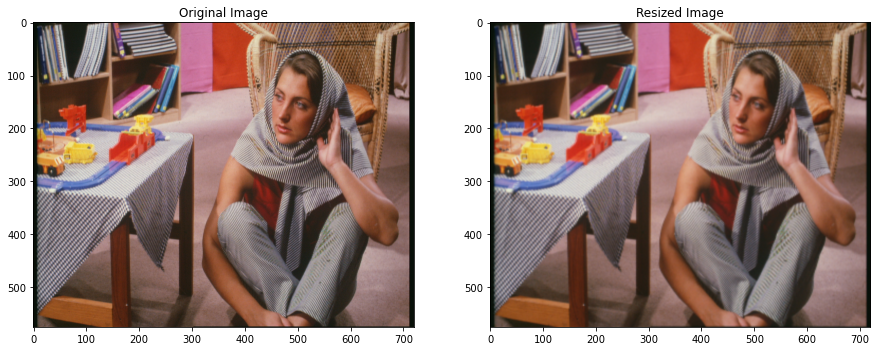

In [9]:
from PIL import Image
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(Image.open('/home/hruday/EDUCATION/major project/SRCNN/data/Train/barbara.png'))
ax[0].title.set_text('Original Image')
ax[1].imshow(Image.open('/home/hruday/EDUCATION/major project/SRCNN/resized/barbara.png'))
ax[1].title.set_text('Resized Image')
plt.show()

In [10]:
# ref - https://github.com/MarkPrecursor/SRCNN-keras/blob/master/prepare_data.py
# Build train dataset
import h5py

names = sorted(os.listdir('/home/hruday/EDUCATION/major project/SRCNN/data/Train'))

data = []
label = []

for name in names:
    fpath = '/home/hruday/EDUCATION/major project/SRCNN/data/Train/' + name
    print(fpath)
    hr_img = cv2.imread(fpath, cv2.IMREAD_COLOR)
    hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
    hr_img = hr_img[:, :, 0]
    shape = hr_img.shape
    
    # resize operation to produce training data and labels
    lr_img = cv2.resize(hr_img, (int(shape[1] / 2), int(shape[0] / 2)))
    lr_img = cv2.resize(lr_img, (shape[1], shape[0]))
    
    width_range = int((shape[0] - 16 * 2) / 16)
    height_range = int((shape[1] - 16 * 2) / 16)
    
    for k in range(width_range):
        for j in range(height_range):
            x = k * 16
            y = j * 16
            
            hr_patch = hr_img[x: x + 32, y: y + 32]
            lr_patch = lr_img[x: x + 32, y: y + 32]
            
            hr_patch = hr_patch.astype(np.float32) / 255.
            lr_patch = lr_patch.astype(np.float32) / 255.
            
            hr = np.zeros((1, 20, 20), dtype=np.double)
            lr = np.zeros((1, 32, 32), dtype=np.double)
            
            hr[0, :, :] = hr_patch[6:-6, 6: -6]
            lr[0, :, :] = lr_patch
            
            label.append(hr)
            data.append(lr)

data = np.array(data, dtype=np.float32)
label = np.array(label, dtype=np.float32)

/home/hruday/EDUCATION/major project/SRCNN/data/Train/baboon.png
/home/hruday/EDUCATION/major project/SRCNN/data/Train/barbara.png
/home/hruday/EDUCATION/major project/SRCNN/data/Train/bridge.png
/home/hruday/EDUCATION/major project/SRCNN/data/Train/coastguard.png
/home/hruday/EDUCATION/major project/SRCNN/data/Train/comic.png
/home/hruday/EDUCATION/major project/SRCNN/data/Train/face.png
/home/hruday/EDUCATION/major project/SRCNN/data/Train/flowers.png
/home/hruday/EDUCATION/major project/SRCNN/data/Train/foreman.png
/home/hruday/EDUCATION/major project/SRCNN/data/Train/lenna.png
/home/hruday/EDUCATION/major project/SRCNN/data/Train/man.png
/home/hruday/EDUCATION/major project/SRCNN/data/Train/monarch.png
/home/hruday/EDUCATION/major project/SRCNN/data/Train/pepper.png
/home/hruday/EDUCATION/major project/SRCNN/data/Train/ppt3.png
/home/hruday/EDUCATION/major project/SRCNN/data/Train/zebra.png


In [11]:
with h5py.File('train.h5', 'w') as h:
    h.create_dataset('data', data=data, shape=data.shape)
    h.create_dataset('label', data=label, shape=label.shape)

In [12]:
# ref - https://github.com/MarkPrecursor/SRCNN-keras/blob/master/prepare_data.py
# Build test dataset

names = sorted(os.listdir('/home/hruday/EDUCATION/major project/SRCNN/data/Test'))
nums = len(names)

data_test = np.zeros((nums * 30, 1, 32, 32), dtype=np.double)
label_test = np.zeros((nums * 30, 1, 20, 20), dtype=np.double)

for i, name in enumerate(names):
    fpath = '/home/hruday/EDUCATION/major project/SRCNN/data/Test/' + name
    hr_img = cv2.imread(fpath, cv2.IMREAD_COLOR)
    print(fpath)
    hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
    hr_img = hr_img[:, :, 0]
    shape = hr_img.shape
    
    # resize operation to produce training data and labels
    lr_img = cv2.resize(hr_img, (int(shape[1] / 2), int(shape[0] / 2)))
    lr_img = cv2.resize(lr_img, (shape[1], shape[0]))
    
    # Produce random crop
    x = np.random.randint(0, min(shape[0], shape[1]) - 32, 30)
    y = np.random.randint(0, min(shape[0], shape[1]) - 32, 30)
    
    for j in range(30):
        lr_patch = lr_img[x[j]:x[j] + 32, y[j]:y[j] + 32]
        hr_patch = hr_img[x[j]:x[j] + 32, y[j]:y[j] + 32]
        
        lr_patch = lr_patch.astype(np.float32) / 255.
        hr_patch = hr_patch.astype(np.float32) / 255.
        
        data_test[i * 30 + j, 0, :, :] = lr_patch
        label_test[i * 30 + j, 0, :, :] = hr_patch[6: -6, 6: -6]

/home/hruday/EDUCATION/major project/SRCNN/data/Test/baby.png
/home/hruday/EDUCATION/major project/SRCNN/data/Test/bird.png
/home/hruday/EDUCATION/major project/SRCNN/data/Test/butterfly.png
/home/hruday/EDUCATION/major project/SRCNN/data/Test/head.png
/home/hruday/EDUCATION/major project/SRCNN/data/Test/woman.png


In [13]:
with h5py.File('test.h5', 'w') as h:
    h.create_dataset('data', data=data_test, shape=data_test.shape)
    h.create_dataset('label', data=label_test, shape=label_test.shape)

In [14]:
# Define the SR-CNN model
def model():
    SRCNN = tf.keras.Sequential(name='SRCNN')
    SRCNN.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(9, 9), 
                                     padding='VALID',
                                     use_bias=True,
                                     input_shape=(None, None, 1),
                                     kernel_initializer='glorot_uniform',
                                     activation='relu'))
    SRCNN.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3),
                                     padding='SAME',
                                     use_bias=True,
                                     kernel_initializer='glorot_uniform',
                                     activation='relu'))
    SRCNN.add(tf.keras.layers.Conv2D(filters=1, kernel_size=(5, 5),
                                     padding='VALID',
                                     use_bias=True,
                                     kernel_initializer='glorot_uniform',
                                     activation='linear'))
    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)
    
    # Compile model
    SRCNN.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return SRCNN

In [15]:
srcnn_model = model()
srcnn_model.summary()

Model: "SRCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 128)   10496     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    73792     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 1)     1601      
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________


In [16]:
with h5py.File('./train.h5', 'r') as h:
    data = np.array(h.get('data'))
    label = np.array(h.get('label'))
    X_train = np.transpose(data, (0, 2, 3, 1))
    y_train = np.transpose(label, (0, 2, 3, 1))
    
with h5py.File('./test.h5', 'r') as h:
    data = np.array(h.get('data'))
    label = np.array(h.get('label'))
    X_test = np.transpose(data, (0, 2, 3, 1))
    y_test = np.transpose(label, (0, 2, 3, 1))
    
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10916, 32, 32, 1), (10916, 20, 20, 1), (150, 32, 32, 1), (150, 20, 20, 1))

In [17]:
checkpoint_path = './srcnn/cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir, save_best_only=True,
                                                 save_weights_only=True, verbose=0)

In [20]:
srcnn_model.fit(X_train, y_train, batch_size=64, validation_data=(X_test, y_test), 
                callbacks=[checkpoint], shuffle=True, epochs=50, verbose=1)

Epoch 1/50
171/171 [==============================] - 108s 634ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 5.7096e-04 - val_mean_squared_error: 5.7096e-04
Epoch 2/50
171/171 [==============================] - 104s 609ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 5.2764e-04 - val_mean_squared_error: 5.2764e-04
Epoch 3/50
171/171 [==============================] - 106s 622ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 6.7255e-04 - val_mean_squared_error: 6.7255e-04
Epoch 4/50
171/171 [==============================] - 130s 761ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 5.1706e-04 - val_mean_squared_error: 5.1706e-04
Epoch 5/50
171/171 [==============================] - 118s 693ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 5.0182e-04 - val_mean_squared_error: 5.0182e-04
Epoch 6/50
171/171 [==============================] - 110s 642ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 4.98

171/171 [==============================] - 60s 349ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 4.1225e-04 - val_mean_squared_error: 4.1225e-04
Epoch 49/50
171/171 [==============================] - 60s 349ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 4.3796e-04 - val_mean_squared_error: 4.3796e-04
Epoch 50/50
171/171 [==============================] - 61s 358ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 4.5242e-04 - val_mean_squared_error: 4.5242e-04


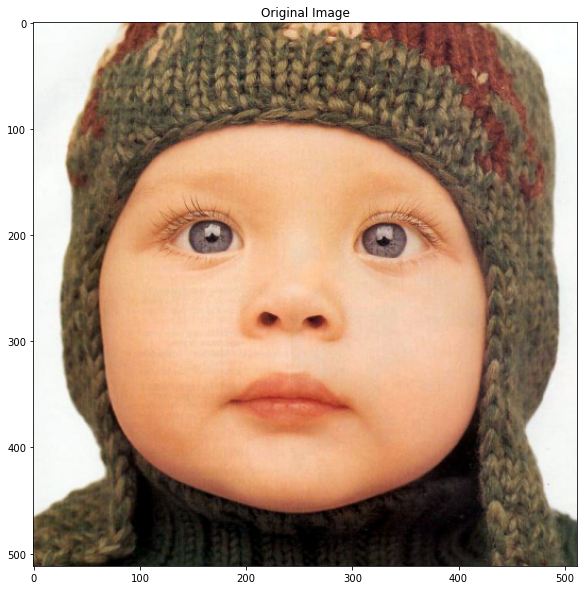

In [21]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(Image.open('/home/hruday/EDUCATION/major project/SRCNN/data/Test/baby.png'))
ax.title.set_text("Original Image")
plt.show()

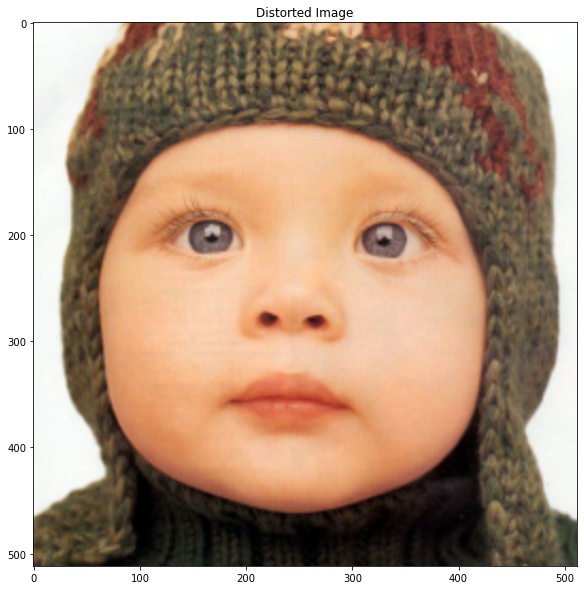

In [23]:
# Make output directory
try:
    os.listdir('/home/hruday/EDUCATION/major project/SRCNN/data/output')
except:
    os.mkdir('/home/hruday/EDUCATION/major project/SRCNN/data/output')

target = cv2.imread('/home/hruday/EDUCATION/major project/SRCNN/data/Test/baby.png', cv2.IMREAD_COLOR)
target = cv2.cvtColor(target, cv2.COLOR_BGR2YCrCb)
shape = target.shape

# Resize down by scale of 2
Y_img = cv2.resize(target[:, :, 0], (int(shape[1] / 2), int(shape[0] / 2)), cv2.INTER_CUBIC)

# Resize up to orignal image
Y_img = cv2.resize(Y_img, (shape[1], shape[0]), cv2.INTER_CUBIC)
target[:, :, 0] = Y_img
target = cv2.cvtColor(target, cv2.COLOR_YCrCb2BGR)
cv2.imwrite('/home/hruday/EDUCATION/major project/SRCNN/data/output/input.jpg', target)

fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(Image.open('/home/hruday/EDUCATION/major project/SRCNN/data/output/input.jpg'))
ax.title.set_text("Distorted Image")
plt.show()

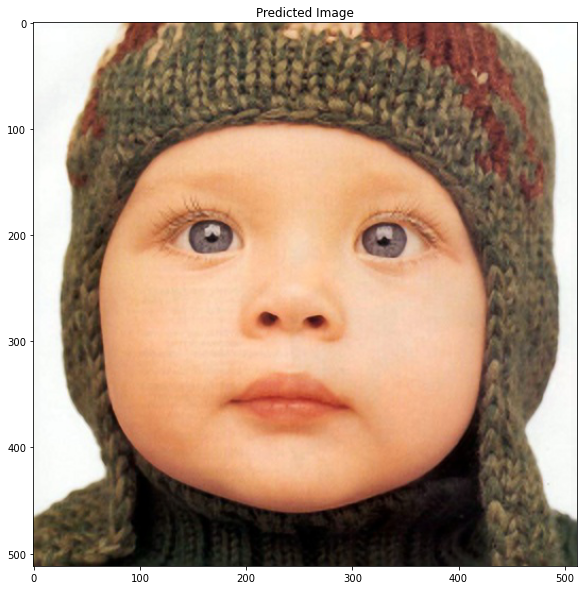

In [24]:
Y = np.zeros((1, target.shape[0], target.shape[1], 1), dtype=np.float32)
# Normalize
Y[0, :, :, 0] = Y_img.astype(np.float32) / 255.

# Predict
pre = srcnn_model.predict(Y, batch_size=1) * 255.

# Post process output
pre[pre[:] > 255] = 255
pre[pre[:] < 0] = 0
pre = pre.astype(np.uint8)

# Copy y channel back to image and convert to BGR
output = cv2.cvtColor(target, cv2.COLOR_BGR2YCrCb)
output[6: -6, 6: -6, 0] = pre[0, :, :, 0]
output = cv2.cvtColor(output, cv2.COLOR_YCrCb2BGR)

# Save image
cv2.imwrite('/home/hruday/EDUCATION/major project/SRCNN/data/output/output.jpg', output)

fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(Image.open('/home/hruday/EDUCATION/major project/SRCNN/data/output/output.jpg'))
ax.title.set_text("Predicted Image")
plt.show()

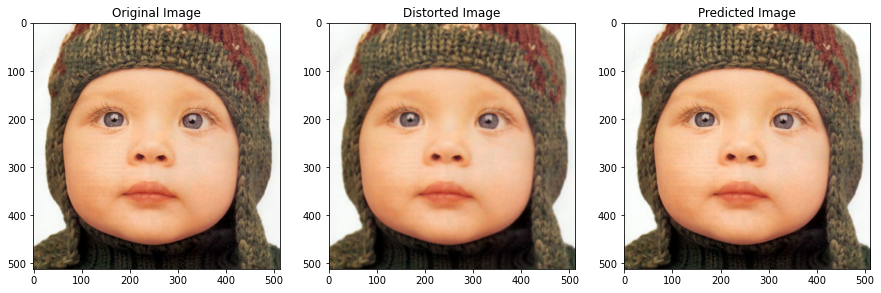

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].imshow(Image.open('/home/hruday/EDUCATION/major project/SRCNN/data/Test/baby.png'))
ax[0].title.set_text("Original Image")

ax[1].imshow(Image.open('/home/hruday/EDUCATION/major project/SRCNN/data/output/input.jpg'))
ax[1].title.set_text("Distorted Image")

ax[2].imshow(Image.open('/home/hruday/EDUCATION/major project/SRCNN/data/output/output.jpg'))
ax[2].title.set_text("Predicted Image")

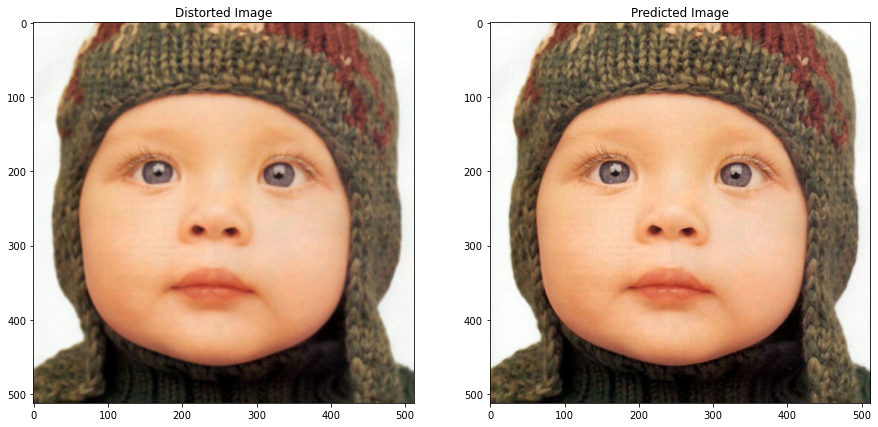

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

ax[0].imshow(Image.open('/home/hruday/EDUCATION/major project/SRCNN/data/output/input.jpg'))
ax[0].title.set_text("Distorted Image")

ax[1].imshow(Image.open('/home/hruday/EDUCATION/major project/SRCNN/data/output/output.jpg'))
ax[1].title.set_text("Predicted Image")

In [28]:
original = cv2.imread('/home/hruday/EDUCATION/major project/SRCNN/data/Test/baby.png')
distorted = cv2.imread('/home/hruday/EDUCATION/major project/SRCNN/data/output/input.jpg')
predicted = cv2.imread('/home/hruday/EDUCATION/major project/SRCNN/data/output/output.jpg')

In [29]:
# Comparing original and distorted image
metrics = compare_images(original, distorted)
print("Metrics for original and distorted image")
print("PSNR: {}".format(metrics[0]))
print("MSE: {}".format(metrics[1]))
print("SSIM: {}".format(metrics[2]))

Metrics for original and distorted image
PSNR: 34.01150043358087
MSE: 77.45536804199219
SSIM: 0.925395546416222


In [30]:
# Comparing original and predicted image
metrics = compare_images(original, predicted)
print("Metrics for original and predicted image")
print("PSNR: {}".format(metrics[0]))
print("MSE: {}".format(metrics[1]))
print("SSIM: {}".format(metrics[2]))

Metrics for original and predicted image
PSNR: 35.17600436813889
MSE: 59.238101959228516
SSIM: 0.9450969369459031


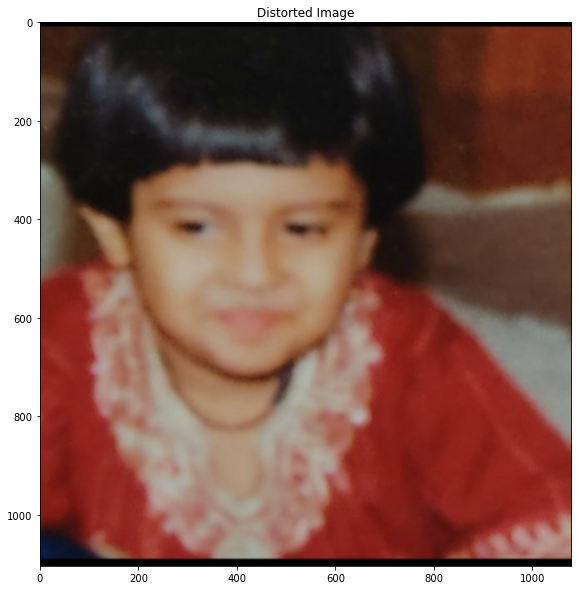

In [38]:
# Make output directory
try:
    os.listdir('/home/hruday/EDUCATION/major project/SRCNN/data/output')
except:
    os.mkdir('/home/hruday/EDUCATION/major project/SRCNN/data/output')

target = cv2.imread('/home/hruday/Downloads/okok.jpg', cv2.IMREAD_COLOR)
target = cv2.cvtColor(target, cv2.COLOR_BGR2YCrCb)
shape = target.shape

# Resize down by scale of 2
Y_img = cv2.resize(target[:, :, 0], (int(shape[1] / 2), int(shape[0] / 2)), cv2.INTER_CUBIC)

# Resize up to orignal image
Y_img = cv2.resize(Y_img, (shape[1], shape[0]), cv2.INTER_CUBIC)
target[:, :, 0] = Y_img
target = cv2.cvtColor(target, cv2.COLOR_YCrCb2BGR)
cv2.imwrite('/home/hruday/EDUCATION/major project/SRCNN/data/output/input1.jpg', target)

fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(Image.open('/home/hruday/EDUCATION/major project/SRCNN/data/output/input1.jpg'))
ax.title.set_text("Distorted Image")
plt.show()

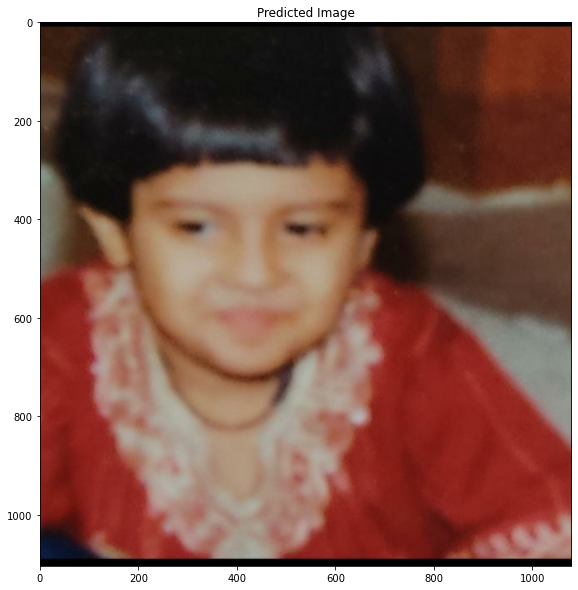

In [40]:
Y = np.zeros((1, target.shape[0], target.shape[1], 1), dtype=np.float32)
# Normalize
Y[0, :, :, 0] = Y_img.astype(np.float32) / 255.

# Predict
pre = srcnn_model.predict(Y, batch_size=1) * 255.

# Post process output
pre[pre[:] > 255] = 255
pre[pre[:] < 0] = 0
pre = pre.astype(np.uint8)

# Copy y channel back to image and convert to BGR
output = cv2.cvtColor(target, cv2.COLOR_BGR2YCrCb)
output[6: -6, 6: -6, 0] = pre[0, :, :, 0]
output = cv2.cvtColor(output, cv2.COLOR_YCrCb2BGR)

# Save image
cv2.imwrite('/home/hruday/EDUCATION/major project/SRCNN/data/output/output1.jpg', output)

fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(Image.open('/home/hruday/EDUCATION/major project/SRCNN/data/output/output1.jpg'))
ax.title.set_text("Predicted Image")
plt.show()

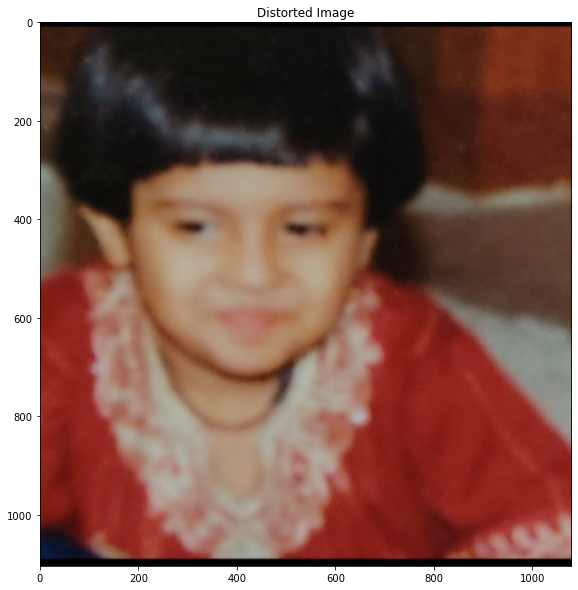

In [41]:
# Make output directory
try:
    os.listdir('/home/hruday/EDUCATION/major project/SRCNN/data/output')
except:
    os.mkdir('/home/hruday/EDUCATION/major project/SRCNN/data/output')

target = cv2.imread('/home/hruday/EDUCATION/major project/SRCNN/data/output/output1.jpg', cv2.IMREAD_COLOR)
target = cv2.cvtColor(target, cv2.COLOR_BGR2YCrCb)
shape = target.shape

# Resize down by scale of 2
Y_img = cv2.resize(target[:, :, 0], (int(shape[1] / 2), int(shape[0] / 2)), cv2.INTER_CUBIC)

# Resize up to orignal image
Y_img = cv2.resize(Y_img, (shape[1], shape[0]), cv2.INTER_CUBIC)
target[:, :, 0] = Y_img
target = cv2.cvtColor(target, cv2.COLOR_YCrCb2BGR)
cv2.imwrite('/home/hruday/EDUCATION/major project/SRCNN/data/output/input2.jpg', target)

fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(Image.open('/home/hruday/EDUCATION/major project/SRCNN/data/output/input2.jpg'))
ax.title.set_text("Distorted Image")
plt.show()

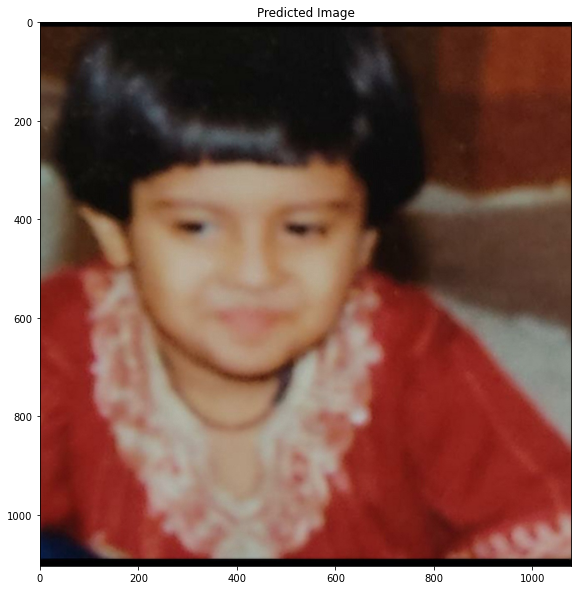

In [42]:
Y = np.zeros((1, target.shape[0], target.shape[1], 1), dtype=np.float32)
# Normalize
Y[0, :, :, 0] = Y_img.astype(np.float32) / 255.

# Predict
pre = srcnn_model.predict(Y, batch_size=1) * 255.

# Post process output
pre[pre[:] > 255] = 255
pre[pre[:] < 0] = 0
pre = pre.astype(np.uint8)

# Copy y channel back to image and convert to BGR
output = cv2.cvtColor(target, cv2.COLOR_BGR2YCrCb)
output[6: -6, 6: -6, 0] = pre[0, :, :, 0]
output = cv2.cvtColor(output, cv2.COLOR_YCrCb2BGR)

# Save image
cv2.imwrite('/home/hruday/EDUCATION/major project/SRCNN/data/output/output2.jpg', output)

fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(Image.open('/home/hruday/EDUCATION/major project/SRCNN/data/output/output2.jpg'))
ax.title.set_text("Predicted Image")
plt.show()

In [43]:
original = cv2.imread('/home/hruday/Downloads/okok.jpg')
distorted = cv2.imread('/home/hruday/EDUCATION/major project/SRCNN/data/output/input2.jpg')
predicted = cv2.imread('/home/hruday/EDUCATION/major project/SRCNN/data/output/output2.jpg')

In [44]:
# Comparing original and distorted image
metrics = compare_images(original, distorted)
print("Metrics for original and distorted image")
print("PSNR: {}".format(metrics[0]))
print("MSE: {}".format(metrics[1]))
print("SSIM: {}".format(metrics[2]))

Metrics for original and distorted image
PSNR: 43.40017561250214
MSE: 8.91628757380569
SSIM: 0.9869054869387844


In [45]:
# Comparing original and predicted image
metrics = compare_images(original, predicted)
print("Metrics for original and predicted image")
print("PSNR: {}".format(metrics[0]))
print("MSE: {}".format(metrics[1]))
print("SSIM: {}".format(metrics[2]))

Metrics for original and predicted image
PSNR: 42.32204804866775
MSE: 11.428698671497585
SSIM: 0.9833701987337494
